нужно сделать conda install cmake
на винде это тут
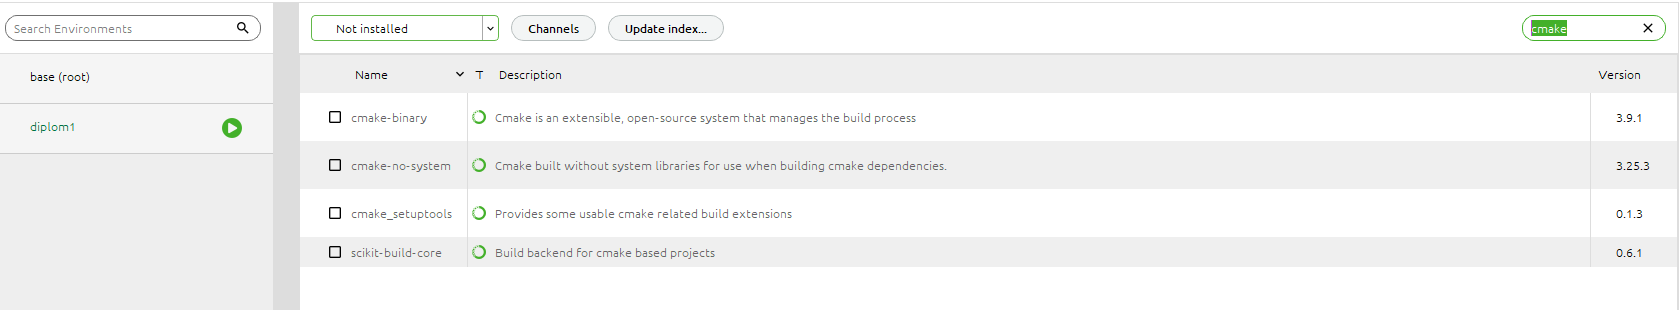

In [1]:
!pip install -q -r requirements.txt

In [2]:
#@title requirements {display-mode:"form"}
# !pip install -q numpy torch torchvision cython_bbox onemetric loguru lap thop opencv-python ultralytics supervision==0.1.0

# %git clone https://github.com/ifzhang/ByteTrack.git
%cd ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
# %sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

# !pip install -q -r requirements.txt
!pip setup.py develop

from IPython import display
display.clear_output()

import ByteTrack.yolox as yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


# utils

In [3]:
#@title yolov8_model {display-mode:"form"}
from ultralytics import YOLO


MODEL = "../best1280.pt"
model = YOLO(MODEL)
model.fuse()


CLASS_NAMES_DICT = model.names
CLASS_ID = [0, 1, 2, 3, 4, 5, 6, 7]

CLASS_ID_BY_NAME = {
    "chair": 0,
    "person": 1,
    "interactive whiteboard": 2,
    "keyboard": 3,
    "laptop": 4,
    "monitor": 5,
    "pc": 6,
    "table": 7,
}

Model summary (fused): 168 layers, 3007208 parameters, 0 gradients, 8.1 GFLOPs


In [4]:
#@title line_counter {display-mode:"form"}
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.geometry.dataclasses import Point, Rect, Vector
from typing import List, Dict
import numpy as np
from supervision.draw.color import Color
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator
import cv2


class CustomLineCounter:
    def __init__(self, start: Point, end: Point, classes: List):
        self.vector = Vector(start=start, end=end)
        self.tracker_state: Dict[str, bool] = {}
        self.start = start
        self.end = end
        self.result_dict = {
            # int(class_id): {"in_count": int(0), "out_count": int(0)}
            int(class_id): {"in": [], "out": []}
            for class_id in classes
        }


    def update(self, detections: Detections):
        for id in detections.class_id:
            mask = np.array(
                [class_id in [int(id)] for class_id in detections.class_id], dtype=bool
            )
            filtereddet = detections.filter(mask=mask, inplace=False)

            for xyxy, confidence, class_id, tracker_id in filtereddet:
                # handle detections with no tracker_id
                if tracker_id is None:
                    continue

                # we check if all four anchors of bbox are on the same side of vector
                x1, y1, x2, y2 = xyxy
                anchors = [
                    Point(x=x1, y=y1),
                    Point(x=x1, y=y2),
                    Point(x=x2, y=y1),
                    Point(x=x2, y=y2),
                ]
                triggers = [self.vector.is_in(point=anchor) for anchor in anchors]

                # detection is partially in and partially out
                if len(set(triggers)) == 2:
                    continue

                tracker_state = triggers[0]
                # handle new detection
                if tracker_id not in self.tracker_state:
                    self.tracker_state[tracker_id] = tracker_state
                    continue

                # handle detection on the same side of the line
                if self.tracker_state.get(tracker_id) == tracker_state:
                    continue

                self.tracker_state[tracker_id] = tracker_state
                if tracker_state:
                    # self.result_dict[int(id)]["in_count"] += 1
                    self.result_dict[int(id)]["in"].append(self.camera.get_time_now())
                else:
                    # self.result_dict[int(id)]["out_count"] += 1
                    self.result_dict[int(id)]["out"].append(self.camera.get_time_now())

    def get_result_dict(self) -> dict:
        return self.result_dict


class CustomLineCounterAnnotator:
    def __init__(
        self,
        thickness: float = 2,
        color: Color = Color.white(),
        text_thickness: float = 2,
        text_color: Color = Color.black(),
        text_scale: float = 0.5,
        text_offset: float = 1.5,
        text_padding: int = 10,
        class_name_dict={},
        video_info=[],
    ):
        self.thickness: float = thickness
        self.color: Color = color
        self.text_thickness: float = text_thickness
        self.text_color: Color = text_color
        self.text_scale: float = text_scale
        self.text_offset: float = text_offset
        self.text_padding: int = text_padding
        self.class_name_dict = class_name_dict
        self.video_info = video_info

    def annotate(self, frame: np.ndarray, line_counter: LineCounter) -> np.ndarray:
        cv2.line(
            frame,
            line_counter.vector.start.as_xy_int_tuple(),
            line_counter.vector.end.as_xy_int_tuple(),
            self.color.as_bgr(),
            self.thickness,
            lineType=cv2.LINE_AA,
            shift=0,
        )
        cv2.circle(
            frame,
            line_counter.vector.start.as_xy_int_tuple(),
            radius=5,
            color=self.text_color.as_bgr(),
            thickness=-1,
            lineType=cv2.LINE_AA,
        )
        cv2.circle(
            frame,
            line_counter.vector.end.as_xy_int_tuple(),
            radius=5,
            color=self.text_color.as_bgr(),
            thickness=-1,
            lineType=cv2.LINE_AA,
        )

        report = ""
        for key in line_counter.result_dict:
            class_name = CLASS_NAMES_DICT[key]
            in_count = line_counter.result_dict[key]["in_count"]
            out_count = line_counter.result_dict[key]["out_count"]
            report += f" | {class_name}: in {in_count} out {out_count}"
        report += " |"

        (report_width, report_height), _ = cv2.getTextSize(
            report, cv2.FONT_HERSHEY_SIMPLEX, self.text_scale, self.text_thickness
        )

        report_x = int(((self.video_info.width) - report_width) / 2)
        report_y = int((150 + report_height) / 2 - self.text_offset * report_height)

        report_background_rect = Rect(
            x=report_x,
            y=report_y - report_height,
            width=report_width,
            height=report_height,
        ).pad(padding=self.text_padding)

        cv2.rectangle(
            frame,
            report_background_rect.top_left.as_xy_int_tuple(),
            report_background_rect.bottom_right.as_xy_int_tuple(),
            self.color.as_bgr(),
            -1,
        )

        cv2.putText(
            frame,
            report,
            (report_x, report_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            self.text_scale,
            self.text_color.as_bgr(),
            self.text_thickness,
            cv2.LINE_AA,
        )

In [5]:
#@title camera {display-mode:"form"}
import datetime


class Camera:
    def __init__(self, id: int, aud: int, line_counter, line_counter_annotator, video_path: str):
        self.id = id
        self.aud = aud
        self.line_counter = line_counter
        self.line_counter_annotator = line_counter_annotator
        self.video_path = video_path

    def get_time_now(self) -> datetime.datetime:
        pass

    def track_video(self):
        # create BYTETracker instance
        byte_tracker = BYTETracker(BYTETrackerArgs())
        # create VideoInfo instance
        video_info = VideoInfo.from_video_path(self.video_path)
        # create frame generator
        generator = get_video_frames_generator(self.video_path)
        # create LineCounter instance
        line_counter = CustomLineCounter(start=self.line_counter.start, end=self.line_counter.end, classes=CLASS_ID)
        # create instance of BoxAnnotator and LineCounterAnnotator
        box_annotator = BoxAnnotator(
            color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2
        )
        line_annotator = CustomLineCounterAnnotator(
            thickness=4,
            text_thickness=1,
            text_scale=0.5,
            class_name_dict=CLASS_NAMES_DICT,
            video_info=video_info,
        )

        # open target video file
        with VideoSink(self.video_path, video_info) as sink:
            # loop over video frames
            for frame in tqdm(generator, total=video_info.total_frames):
                # model prediction on single frame and conversion to supervision Detections
                results = model(frame)
                detections = Detections(
                    xyxy=results[0].boxes.xyxy.cpu().numpy(),
                    confidence=results[0].boxes.conf.cpu().numpy(),
                    class_id=results[0].boxes.cls.cpu().numpy().astype(int),
                )

                # filtering out detections with unwanted classes
                mask = np.array(
                    [class_id in CLASS_ID for class_id in detections.class_id], dtype=bool
                )
                detections.filter(mask=mask, inplace=True)

                # tracking detections
                tracks = byte_tracker.update(
                    output_results=detections2boxes(detections=detections),
                    img_info=frame.shape,
                    img_size=frame.shape,
                )

                tracker_id = match_detections_with_tracks(
                    detections=detections, tracks=tracks
                )

                detections.tracker_id = np.array(tracker_id)

                # filtering out detections without trackers
                mask = np.array(
                    [tracker_id is not None for tracker_id in detections.tracker_id],
                    dtype=bool,
                )
                detections.filter(mask=mask, inplace=True)
                # format custom labels
                labels = [
                    f"id{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
                    for _, confidence, class_id, tracker_id in detections
                ]
                frame = box_annotator.annotate(
                    frame=frame, detections=detections, labels=labels
                )

                line_counter.update(detections=detections)
                line_annotator.annotate(frame=frame, line_counter=self.line_counter)

                sink.write_frame(frame)
        return line_counter.result_dict

    def get_tracker_info(
        self,
    ) -> dict:
        return self.line_counter.get_result_dict()

In [6]:
#@title tracker {display-mode:"form"}
import cv2
import matplotlib.pyplot as plt
import sys
import supervision
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator
from typing import List
import numpy as np
from tqdm.notebook import tqdm
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass
from typing import Dict
import cv2
import numpy as np
from supervision.draw.color import Color
from supervision.geometry.dataclasses import Point, Rect, Vector
from supervision.tools.detections import Detections


class VideoProcessor:
    def __init__(
        self,
        video_path,
    ):
        self.video_path = video_path
        self.video = cv2.VideoCapture(video_path)
        self.width = int(self.video.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.height = int(self.video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    def get_frame_by_order(self, frame_number):
        self.video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = self.video.read()
        if ret:
            return frame
        else:
            return None

    def get_width_height(self):
        return self.width, self.height


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((detections.xyxy, detections.confidence[:, np.newaxis]))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([track.tlbr for track in tracks], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections, tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids


def track_video(
    SOURCE_VIDEO_PATH,
    LINE_START,
    LINE_END,
    CLASS_ID,
    TARGET_VIDEO_PATH,
    CLASS_NAMES_DICT,
    model,
):
    # create BYTETracker instance
    byte_tracker = BYTETracker(BYTETrackerArgs())
    # create VideoInfo instance
    video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
    # create frame generator
    generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
    # create LineCounter instance
    line_counter = CustomLineCounter(start=LINE_START, end=LINE_END, classes=CLASS_ID)
    # create instance of BoxAnnotator and LineCounterAnnotator
    box_annotator = BoxAnnotator(
        color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2
    )
    line_annotator = CustomLineCounterAnnotator(
        thickness=4,
        text_thickness=1,
        text_scale=0.5,
        class_name_dict=CLASS_NAMES_DICT,
        video_info=video_info,
    )

    # open target video file
    with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
        # loop over video frames
        for frame in tqdm(generator, total=video_info.total_frames):
            # model prediction on single frame and conversion to supervision Detections
            results = model(frame)
            detections = Detections(
                xyxy=results[0].boxes.xyxy.cpu().numpy(),
                confidence=results[0].boxes.conf.cpu().numpy(),
                class_id=results[0].boxes.cls.cpu().numpy().astype(int),
            )

            # filtering out detections with unwanted classes
            mask = np.array(
                [class_id in CLASS_ID for class_id in detections.class_id], dtype=bool
            )
            detections.filter(mask=mask, inplace=True)

            # tracking detections
            tracks = byte_tracker.update(
                output_results=detections2boxes(detections=detections),
                img_info=frame.shape,
                img_size=frame.shape,
            )

            tracker_id = match_detections_with_tracks(
                detections=detections, tracks=tracks
            )

            detections.tracker_id = np.array(tracker_id)

            # filtering out detections without trackers
            mask = np.array(
                [tracker_id is not None for tracker_id in detections.tracker_id],
                dtype=bool,
            )
            detections.filter(mask=mask, inplace=True)
            # format custom labels
            labels = [
                f"id{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
                for _, confidence, class_id, tracker_id in detections
            ]
            frame = box_annotator.annotate(
                frame=frame, detections=detections, labels=labels
            )

            line_counter.update(detections=detections)
            line_annotator.annotate(frame=frame, line_counter=line_counter)

            sink.write_frame(frame)
    return line_counter.result_dict

# _

In [17]:
coords = [[1100, 230],[1200, 750]]
video_path = 'E:\kin\Study\8\Diplom\diplom\palace.mp4'
video_info = VideoInfo.from_video_path(video_path)

camera = Camera(
    id=1,
    aud=21,
    line_counter=CustomLineCounter(
        Point(0, 0),
        Point(0, 0),
        classes=CLASS_ID
    ),
    line_counter_annotator=CustomLineCounterAnnotator(
        class_name_dict=CLASS_NAMES_DICT,
        thickness=4,
        text_thickness=1,
        text_scale=0.5,
        video_info=video_info
    ),
    video_path = video_path
)

Exception: Could not open video at E:\kin\Study\8\Diplom\diplom\palace.mp4

In [11]:
camera.track_video()

NameError: name 'camera' is not defined